<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model Interpretation using RISE for timeseries data
This notebook shows how to apply the RISE explainability method on a model trained to classify Fast Radio Burst (FRB) timeseries data. The model is a binary classifier that classifies the input a either noise or a real FRB.<br>

RISE is short for Randomized Input Sampling for Explanation of Black-box Models. It estimates the relevance empirically by probing the model with randomly masked versions of the input image to obtain the corresponding outputs.<br>

More details about this method can be found in the paper https://arxiv.org/abs/1806.07421.<br>

#### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]
  
    # download data used in this demo
    import os 
    base_url = 'https://raw.githubusercontent.com/dianna-ai/dianna/main/tutorials/'
    paths_to_download = ['data/arts_frb_classes.txt', 'data/FRB211024.npy']
    for path in paths_to_download:
        !wget {base_url + path} -P {os.path.dirname(path)}

In [2]:
# Download model from zenodo
import os
from urllib.request import urlretrieve

model_url = "https://zenodo.org/record/10656614/files/apertif_frb_dynamic_spectrum_model.onnx?download=1"
model_path = 'models/apertif_frb_dynamic_spectrum_model.onnx'

if not os.path.isfile(model_path):
    print("Downloading model")
    urlretrieve(model_url, model_path)

### Libraries

In [3]:
import numpy as np
from dianna import visualization
from matplotlib import pyplot as plt
import dianna
from dianna.visualization import plot_timeseries

np.random.seed(0)

In [4]:
classes_path = 'data/apertif_frb_classes.txt'
data_path = 'data/FRB211024.npy'

## Loading the data

In [5]:
data = np.load(data_path)

Text(0.5, 1.0, 'FRB 211024')

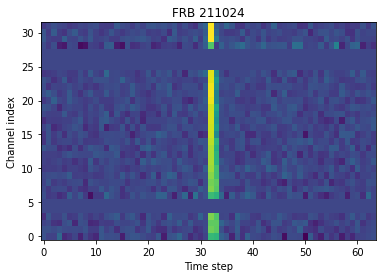

In [6]:
fig, ax = plt.subplots()
ax.imshow(data, aspect='auto', origin='lower')
ax.set_xlabel('Time step')
ax.set_ylabel('Channel index')
ax.set_title('FRB 211024')

## Selecting the class to run the explainer for

In [7]:
with open(classes_path) as fp:
    class_names = [line.strip() for line in fp.readlines()]
    
print(f"{class_names=}")
    
class_to_explain = 'FRB'
    
labels = [class_names.index(class_to_explain)]

class_names=['Noise', 'FRB']


## Define function to handle difference between data shape expected by DIANNA and model|

Dianna expects input with shape `(time, channel)` while the model and data use `(channel, time)`
In addition, the model needs an extra emtpy axis at the end. 
(model detail: this is because the model is a CNN and the input is processed as if it is an image. The empty axis at the end is the "colour channel" axis)

To handle this, we transpose the input data before feeding it to DIANNA and we define a preprocess function that is called on the data just before it is given to the model. DIANNA creates masked data in batches, so the preprocess function receives data with shape `(batch, time, channel)` which we need to convert to `(batch, channel, time, 1)`. We also convert to `float32`, as this is the only floating point format handled by models in ONNX format.

In [8]:
def preprocess(data):
    return np.transpose(data, (0, 2, 1))[..., None].astype(np.float32)

## Run the explainer

In [9]:
# Run the explainer with 5000 masks and a feature resolution of 8 samples
# Masked values are replaced by the mean of the input data
explanation = dianna.explain_timeseries(model_path, data.T, method='RISE', labels=labels,
                                        n_masks=5000, feature_res=8, preprocess_function=preprocess,
                                        mask_type='mean')


# select heatmap of the first (and only) class we ran the explainer for
heatmap = explanation[0].T

Explaining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.27it/s]


## Plot the explanation and input data next to each other

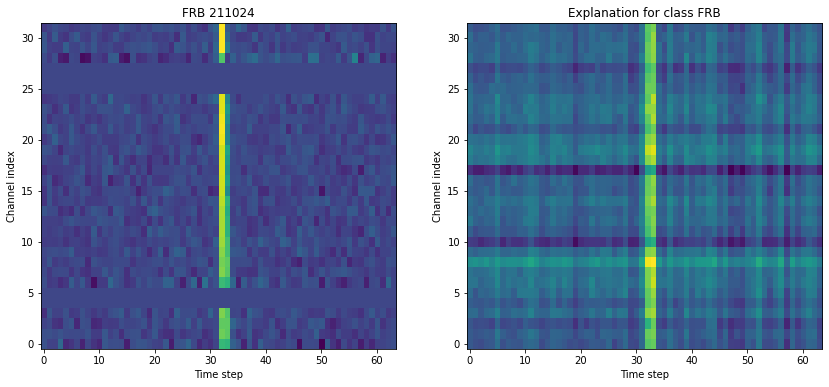

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

ax = axes[0]
ax.imshow(data, aspect='auto', origin='lower')
ax.set_xlabel('Time step')
ax.set_ylabel('Channel index')
ax.set_title('FRB 211024')

ax = axes[1]
ax.imshow(heatmap, aspect='auto', origin='lower')
ax.set_xlabel('Time step')
ax.set_ylabel('Channel index')
ax.set_title(f'Explanation for class {class_to_explain}');

## Results

From the explainer output, we can clearly see that the model is mostly influenced by the vertical line in the center, which is exactly where the real FRB is located. Curiously, it is also influenced by channels that are completely masked out in the input data.